In [13]:
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [14]:
df=pd.read_pickle("./LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [15]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [18]:
df = df.drop(['waferIndex'], axis = 1)

In [19]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
23097,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",939.0,lot2634,[],[],"(39, 31)"
232220,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2507.0,lot14539,[],[],"(52, 63)"
578604,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot36153,[],[],"(33, 33)"
667588,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",712.0,lot41573,[],[],"(32, 29)"
417040,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2367.0,lot24902,[],[],"(51, 59)"


In [20]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [21]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [22]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


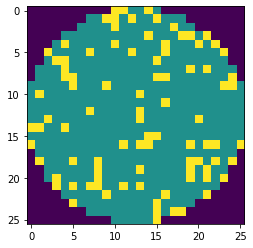

Faulty case : ['none'] 


In [23]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [24]:
#add channel
x = x.reshape((-1, 26, 26, 1))

In [25]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [26]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [27]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [28]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

In [29]:
# parameter
epoch=15
batch_size=1024

In [30]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [31]:
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________

In [32]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/15
15/15 - 57s - loss: 0.1556
Epoch 2/15
15/15 - 57s - loss: 0.0978
Epoch 3/15
15/15 - 57s - loss: 0.0868
Epoch 4/15
15/15 - 57s - loss: 0.0761
Epoch 5/15
15/15 - 57s - loss: 0.0666
Epoch 6/15
15/15 - 57s - loss: 0.0593
Epoch 7/15
15/15 - 56s - loss: 0.0533
Epoch 8/15
15/15 - 57s - loss: 0.0485
Epoch 9/15
15/15 - 57s - loss: 0.0439
Epoch 10/15
15/15 - 56s - loss: 0.0390
Epoch 11/15
15/15 - 57s - loss: 0.0343
Epoch 12/15
15/15 - 57s - loss: 0.0303
Epoch 13/15
15/15 - 58s - loss: 0.0269
Epoch 14/15
15/15 - 57s - loss: 0.0241
Epoch 15/15
15/15 - 57s - loss: 0.0219


In [33]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [34]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [35]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

In [36]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

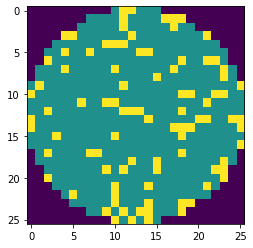

In [37]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

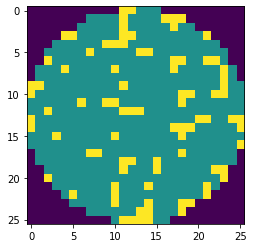

In [38]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

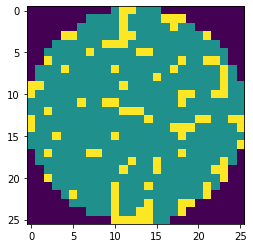

In [39]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])

In [40]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [41]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [42]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [43]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [44]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [45]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [46]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [47]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [48]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [49]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [50]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (13203, 26, 26, 3), y : (13203, 9)
Test x: (6504, 26, 26, 3), y : (6504, 9)


In [51]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [52]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10
9/9 - 158s - loss: 2.4279 - accuracy: 0.2994
Epoch 2/10
9/9 - 160s - loss: 1.1214 - accuracy: 0.5860
Epoch 3/10
9/9 - 157s - loss: 0.6547 - accuracy: 0.7477
Epoch 4/10
9/9 - 160s - loss: 0.3669 - accuracy: 0.8862
Epoch 5/10
9/9 - 159s - loss: 0.2031 - accuracy: 0.9355
Epoch 6/10
9/9 - 161s - loss: 0.1109 - accuracy: 0.9680
Epoch 7/10
9/9 - 161s - loss: 0.0706 - accuracy: 0.9828
Epoch 8/10
9/9 - 160s - loss: 0.0402 - accuracy: 0.9911
Epoch 9/10
9/9 - 160s - loss: 0.0244 - accuracy: 0.9956
Epoch 10/10
9/9 - 159s - loss: 0.0178 - accuracy: 0.9972
5/5 - 25s - loss: 0.0419 - accuracy: 0.9886
Epoch 1/10
9/9 - 157s - loss: 2.2267 - accuracy: 0.2649
Epoch 2/10
9/9 - 158s - loss: 1.1463 - accuracy: 0.6132
Epoch 3/10
9/9 - 159s - loss: 0.6884 - accuracy: 0.7929
Epoch 4/10
9/9 - 158s - loss: 0.3446 - accuracy: 0.8874
Epoch 5/10
9/9 - 158s - loss: 0.1791 - accuracy: 0.9479
Epoch 6/10
9/9 - 159s - loss: 0.0967 - accuracy: 0.9746
Epoch 7/10
9/9 - 158s - loss: 0.0512 - accuracy: 0.9880
Epo

In [ ]:
pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

In [ ]:
new_y_test=np.zeros(len(pred))

for i in range(len(pred)):
    for j in range(len(y_test[0])):
        if y_test[i][j]==1:
            new_y_test[i]=j
            break

In [ ]:
cnf_matrix = confusion_matrix(new_y_test,pred)

In [ ]:
cnf_matrix

In [ ]:
# confusion matrix 그리는 함수 
def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = con_mat.max() / 2.
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cnf_matrix, labels=faulty_case, normalize=True)